 There is a number of models of population growth. Three of the most popular are: logistic, Gomperts and
Richards models (see e.g. [TW02]). Try to find the best mean-square fit of each of these models for the data
about the population in Poland from 1950 to 2020 that can be found on macrotrends.net. Apply each of
the three models to find the population in 2021. Which gives the best estimate? Which had the smallest
mean-square error?
To find the best-fitting curves apply the Newton method with stepsize computed using Armijo rule.
[TW02] A.N. Tsoularis, J. Wallace, Analysis of Logistic Growth Models. Mathematical Biosciences 179(1):
21–55 (2002)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from pydantic import BaseModel

$$
MSE=\frac{1}{N}\sum^N_{i=1}(y_i-N(t_i))^2
$$

## Logistic model

$$
N(t;K,N_0,r)=\frac{KN_0}{(K-N_0)e^{-rt}+N_0}=\frac{A}{(K-N_0)E+N_0}=\frac{A}{C}
$$

$$
\frac{\partial}{\partial K}N=\frac{N_0C-AE}{D^2},\quad \frac{\partial}{\partial N_0}N=\frac{KC-A(1-E)}{D^2},\quad \frac{\partial}{\partial K}r=\frac{N_0C-AE}{D^2}\quad 
$$

$$
MSE(K,N_0,r)=\frac{1}{N}\sum^N_{i=1}(y_i-N(t_i;K,N_0,r))^2
$$

In [ ]:
class LogisticGrowthParams(BaseModel):
    K: float
    N0: float
    r: float

class LogisticGrowth:
    def __init__(self, params: LogisticGrowthParams) -> None:
        self.K = params.K
        self.N0 = params.N0
        self.r = params.r
        
    def set_params(self, params: LogisticGrowthParams) -> None:
        """Used in updates in next Netwon-Rhapson steps."""
        self.K = params.K
        self.N0 = params.N0
        self.r = params.r
        
    
    def coefs(self, t: np.ndarray) -> dict[str, np.ndarray | float]:
        """Useful ingredients mapping for Jacobian calculations."""
        exp_val = np.exp(-self.r*t)
        return {
            "A": self.K*self.N0,
            "E": exp_val,
            "D": (self.K-self.N0)*exp_val + self.N0
        }
    
    def jacobian(self, t: np.ndarray) -> np.ndarray:
        coefs = self.coefs(t)
        D2=coefs["D"]
        dfdK = (self.N0 * coefs["D"] - coefs["A"] * coefs["E"]) / (D2)
        dfdN0 = (self.K * coefs["D"] - coefs["A"] * (1 - coefs["E"])) / (D2)
        dfdR = coefs["A"] * (self.K - self.N0) * (t * coefs["E"]) / (D2)
        return np.vstack([dfdK, dfdN0, dfdR]).T   # shape (N,3)
    
    def __call__(self, t: np.ndarray) -> np.ndarray:
        coefs = self.coefs(t)
        return coefs["A"] / coefs["D"]

    def residuals(self, t: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self(t) - y

    def hessian(self, t: np.ndarray):
        """The trick substitution:
        u=A, v=D and computing all partial derivatives
        f_ij = (u_ij v - u_i v_j - u_j v_i - u v_ij)/v^2 + 2 u v_i v_j / v^3
        """
        N = t.size
        coefs = self.coefs(t)
        u = coefs["A"]
        #derivatives order
        # K, N0, r
        du = np.array([self.N0, self.K, 0.0])
        ddu = np.array([
            [0.0, 1.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
        ])
        dvdk = coefs["E"]
        dvdN0 = 1.0 - coefs["E"]

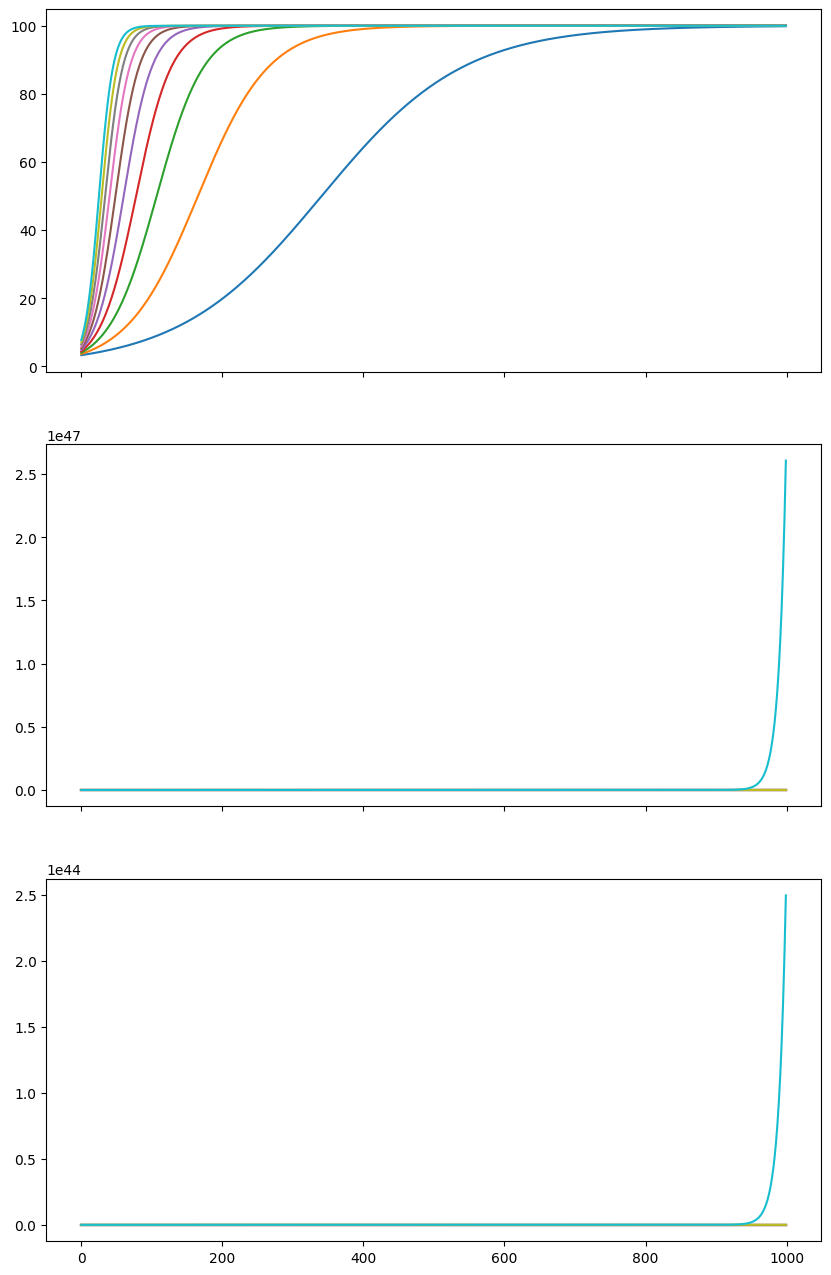

In [3]:
rs = np.linspace(0.1, 1, 10)
example_models = [LogisticGrowth(K=100, N0=3, r=r) for r in rs]
ts = np.linspace(1, 100, 1000)
fig, ax = plt.subplots(3, 1, figsize=(10, 16), sharex=True)
for r, model in zip(rs, example_models):
    ax[0].plot(model.x(ts), label=f"r={r}")
for r, model in zip(rs, example_models):
    ax[1].plot(model.dx(ts), label=f"r={r}")
for r, model in zip(rs, example_models):
    ax[2].plot(model.ddx(ts), label=f"r={r}")

In [4]:
def mse(y, y_pred):
    return np.mean((y - y_pred)**2)

In [5]:
real_data = pl.read_csv("population.csv")
years = real_data["Year"].to_numpy()[:-5]
populations = real_data["Population"].to_numpy()[:-5]

In [ ]:
constrains = {
    "K": (3e6, 120e6),
    "N0": (0, 1e8),
    "r": (0, 0.2),
}
t0 = 1950
def fit_logistic_numpy(ts, xs, constrains, steps=1000):
    K_values = np.linspace(*constrains["K"], steps)
    r_values = np.linspace(*constrains["r"], steps)
    N0_values = np.linspace(*constrains["N0"], steps)

    best_params = None
    best_mse = np.inf

    # Full grid search
    for K in K_values:
        for r in r_values:
            for N0 in N0_values:
                model = LogisticGrowth(K=K, N0=N0, r=r)
                preds = model.x(ts)
                current_mse = mse(xs, preds)

                if current_mse < best_mse:
                    best_mse = current_mse
                    best_params = (K, r, N0)

    return best_params, best_mse

params, error = fit_logistic_numpy(
    years-t0, populations, constrains=constrains,
    steps=50
)

K_opt, r_opt, N0_opt = params

print("Optimal parameters:")
print(f"K = {K_opt}")
print(f"r = {r_opt}")
print(f"N0 = {N0_opt}")
print("\nLowest MSE =", error)


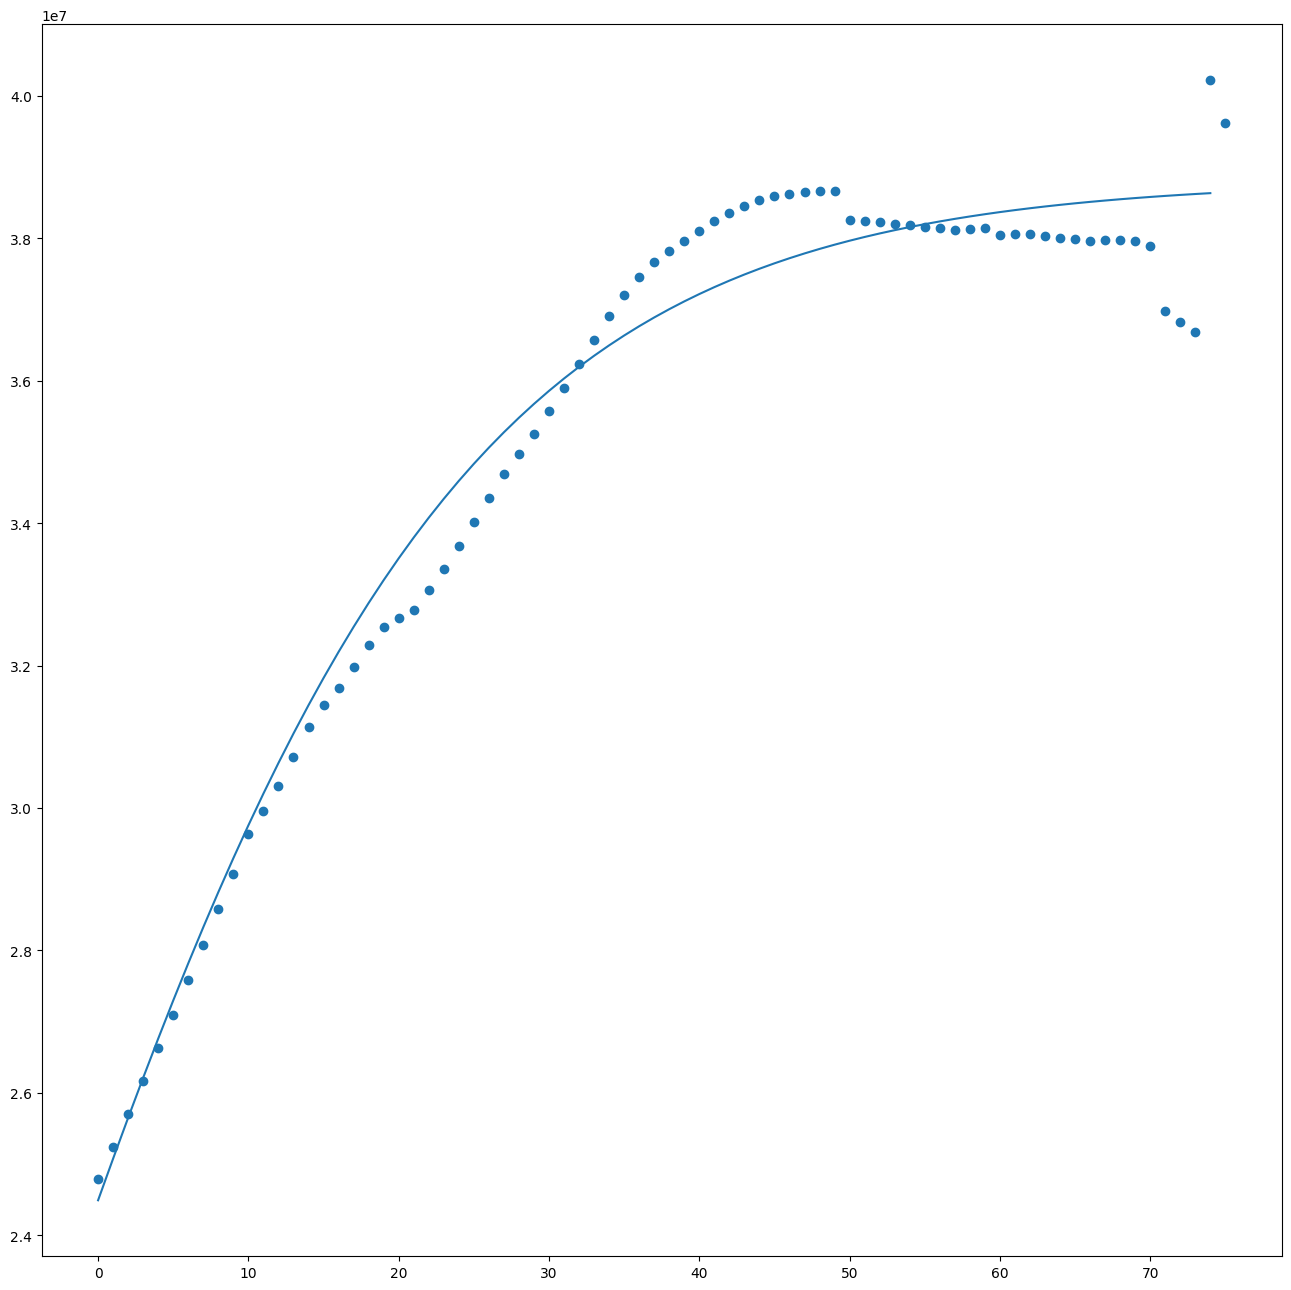

In [ ]:
model_fit = LogisticGrowth(K=K_opt, N0=N0_opt, r=r_opt)
ts = np.arange(1950, 2025) - 1950
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.plot(ts, model_fit.x(ts))
ax.scatter(real_data["Year"]-t0, real_data["Population"])

In [ ]:
def newton_method(model, x0: float, M: int, beta: float, delta: float, s:float) -> list[float]:
    """1D implementation for Newton method."""
    xs = [x0]
    for i in range(M):
        xi = xs[i]
        Dk = model.ddx(xi) ** (-1)
        ak = get_armijo_stepsize(model, s, xi, Dk, beta, delta)
        x_new = xi - ak * Dk * model.dx(xi)
        xs.append(x_new)
    return xs

def get_armijo_stepsize(model, s: float, x: float, Dk: float, beta: float, delta: float):
    a = s
    while model.x(x - a*Dk*model.dx(x)) >= (model.x(x) - delta*a*model.dx(x)*Dk*model.dx(x)):
        print(a)
        a *= beta
    return a

In [ ]:

def aux(t, p):
    """Return A, E, D and simple precomputed scalars used in derivatives."""
    K, N0, r = p
    E = np.exp(-r * t)               # shape (N,)
    A = K * N0
    D = (K - N0) * E + N0            # shape (N,)
    return A, E, D

# # ---------------------------
# # Analytic first derivatives
# ---------------------------
def jacobian_and_residual(t, y, p):
    K, N0, r = p
    A, E, D = aux(t, p)
    f = A / D
    r_vec = f - y

    # first derivatives (vectorized over t)
    dfdK = (N0 * D - A * E) / (D**2)
    dfdN0 = (K * D - A * (1 - E)) / (D**2)
    dfdR = A * (K - N0) * (t * E) / (D**2)

    J = np.vstack([dfdK, dfdN0, dfdR]).T   # shape (N,3)
    return f, r_vec, J

# ---------------------------
# Analytic Hessian using u,v decomposition
# ---------------------------
def analytic_hessian(t, p):
    """Return per-sample second derivative components then sum into Hessian.
       Uses formula:
         f_ij = (u_ij v - u_i v_j - u_j v_i - u v_ij)/v^2 + 2 u v_i v_j / v^3
       where u = K*N0, v = D(t).
    """
    K, N0, r = p
    A, E, D = aux(t, p)
    N = t.size

    # u derivatives
    u = A
    u1 = np.array([N0, K, 0.0])   # [u_K, u_N0, u_r]
    # u second derivs (matrix)
    u2 = np.array([[0.0, 1.0, 0.0],
                   [1.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0]])   # u_KN0 = u_N0K = 1

    # v derivatives (per-sample)
    v = D
    v1_K = E
    v1_N0 = 1.0 - E
    v1_r = -(K - N0) * (t * E)

    # second derivatives of v (per-sample)
    v2_KK = 0.0
    v2_KN0 = 0.0
    v2_N0N0 = 0.0
    v2_Kr = -t * E
    v2_N0r = t * E
    v2_rr = (K - N0) * (t**2) * E

    # pack v1 and v2 so we can iterate
    v1 = np.vstack([v1_K, v1_N0, v1_r])   # (3, N)
    # v2 as functions producing scalar arrays for each (i,j)
    v2 = np.empty((3,3, t.size), dtype=float)
    # fill symmetric v2[i,j]
    v2[0,0,:] = v2_KK
    v2[0,1,:] = v2_KN0
    v2[1,0,:] = v2_KN0
    v2[1,1,:] = v2_N0N0
    v2[0,2,:] = v2_Kr
    v2[2,0,:] = v2_Kr
    v2[1,2,:] = v2_N0r
    v2[2,1,:] = v2_N0r
    v2[2,2,:] = v2_rr

    # assemble Hessian by summing per-sample contributions
    H = np.zeros((3,3), dtype=float)
    for i in range(3):
        for j in range(3):
            # u_ij scalar (constant across t)
            uij = u2[i, j]
            # v_ij is an array over samples
            vij = v2[i, j, :]
            vi = v1[i, :]
            vj = v1[j, :]
            ui = u1[i]
            uj = u1[j]

            term1 = uij * v                 # array
            term2 = - ui * vj               # array
            term3 = - uj * vi               # array
            term4 = - u * vij               # array
            numer = term1 + term2 + term3 + term4    # array
            part = numer / (v**2) + 2.0 * u * (vi * vj) / (v**3)
            # sum across samples and multiply by (2/N) later (for MSE second deriv)
            H[i, j] = np.sum(part)

    return H   # note: this is sum over samples; caller will scale by (2/N) as needed

# ---------------------------
# Full MSE, gradient, Hessian (analytic)
# ---------------------------
def mse_grad_hess_analytic(t, y, p):
    N = t.size
    f, r_vec, J = jacobian_and_residual(t, y, p)
    mse = np.mean(r_vec**2)
    grad = (2.0 / N) * (J.T @ r_vec)
    # Gauss-Newton term:
    GN = (2.0 / N) * (J.T @ J)
    # exact second-derivative correction from analytic_hessian:
    Hcorr_sum = analytic_hessian(t, p)
    Hcorr = (2.0 / N) * Hcorr_sum
    H = GN + Hcorr
    # ensure symmetry
    H = 0.5 * (H + H.T)
    return mse, grad, H

# ---------------------------
# Armijo backtracking (standard)
# ---------------------------
def armijo_backtracking(func_phi, p, d, phi0, gTd, alpha0=1.0, rho=0.5, c=1e-4, max_iters=30):
    alpha = alpha0
    for _ in range(max_iters):
        phi_new = func_phi(p + alpha * d)
        if phi_new <= phi0 + c * alpha * gTd:
            return alpha, phi_new
        alpha *= rho
    return alpha, func_phi(p + alpha * d)

# ---------------------------
# Newton-Raphson with Armijo & damping fallback
# ---------------------------
def newton_armijo_analytic(t, y, p0, tol_grad=1e-8, tol_step=1e-10, max_iter=100):
    p = np.array(p0, dtype=float)
    history = {"mse": [], "grad_norm": [], "p": []}
    N = t.size

    for k in range(max_iter):
        phi, grad, H = mse_grad_hess_analytic(t, y, p)
        gnorm = np.linalg.norm(grad)
        history["mse"].append(phi)
        history["grad_norm"].append(gnorm)
        history["p"].append(p.copy())

        if gnorm < tol_grad:
            break

        # damping to ensure H is solvable / not too indefinite
        damping = 0.0
        success = False
        while True:
            try:
                Hd = H + damping * np.eye(3)
                d = np.linalg.solve(Hd, -grad)
                success = True
                break
            except np.linalg.LinAlgError:
                if damping == 0:
                    damping = 1e-8
                else:
                    damping *= 10
                if damping > 1e6:
                    break
        if not success:
            # fallback to negative gradient direction (steepest descent)
            d = -grad

        gTd = grad.dot(d)
        if gTd >= 0:
            d = -grad
            gTd = grad.dot(d)

        phi0 = phi
        func_phi = lambda pp: mse_grad_hess_analytic(t, y, pp)[0]
        alpha, phi_new = armijo_backtracking(func_phi, p, d, phi0, gTd)
        p_new = p + alpha * d

        history["mse"].append(phi_new)
        history["p"].append(p_new.copy())

        if np.linalg.norm(p_new - p) < tol_step:
            p = p_new
            break

        p = p_new

    return p, history

# ---------------------------
# Example usage (synthetic)
# ---------------------------
if __name__ == "__main__":
    y=populations
    t=years-1950
    K = 36816326
    r = 0.04
    N0 = 23489795

    p0 = np.array([K, N0, r])   # initial guess
    p_est, hist = newton_armijo_analytic(t, y, p0, max_iter=200)
    print("Estimated:", p_est)
    print("Final MSE:", hist["mse"][-1])


Estimated: [3.90143735e+07 2.42963347e+07 6.29264510e-02]
Final MSE: 297905732989.1994


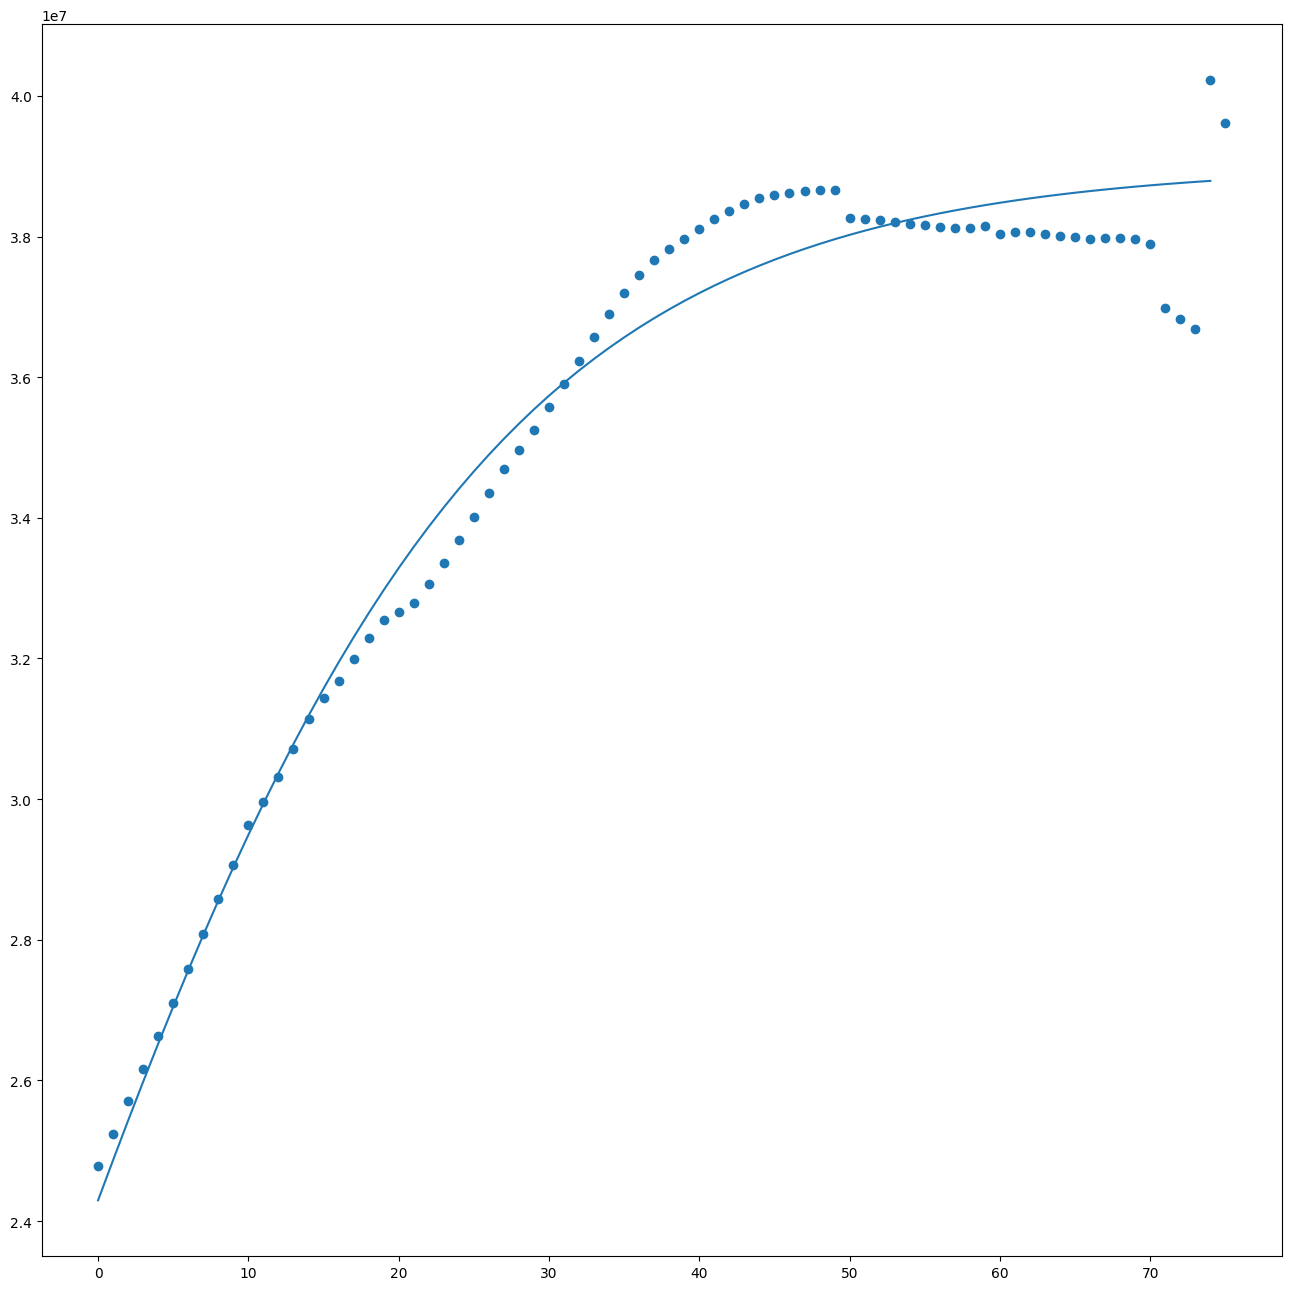

In [ ]:
model_fit = LogisticGrowth(K=p_est[0], N0=p_est[1], r=p_est[2])
ts = np.arange(1950, 2025) - 1950
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.plot(ts, model_fit.x(ts))
ax.scatter(real_data["Year"]-t0, real_data["Population"])

In [ ]:
newton_method(
    LogisticGrowth(K=100, N0=1, r=0.1), s=1, x0=1, beta=0.1, delta=0.03, M=100
,)

1
0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
1.0000000000000004e-05
1.0000000000000004e-06
1.0000000000000005e-07
1.0000000000000005e-08
1.0000000000000005e-09
1.0000000000000006e-10
1.0000000000000006e-11
1.0000000000000006e-12
1.0000000000000007e-13
1.0000000000000008e-14
1.0000000000000009e-15
1.000000000000001e-16
1.000000000000001e-17
1.000000000000001e-18
1.000000000000001e-19
1.0000000000000011e-20
1.0000000000000012e-21
1.0000000000000012e-22
1.0000000000000013e-23
1.0000000000000014e-24
1.0000000000000014e-25
1.0000000000000015e-26
1.0000000000000015e-27
1.0000000000000015e-28
1.0000000000000016e-29
1.0000000000000017e-30
1.0000000000000016e-31
1.0000000000000017e-32
1.0000000000000018e-33
1.0000000000000019e-34
1.0000000000000019e-35
1.000000000000002e-36
1.000000000000002e-37
1.000000000000002e-38
1.000000000000002e-39
1.0000000000000022e-40
1.0000000000000022e-41
1.0000000000000023e-42
1.0000000000000023e-43
1.0000000000000023e-44
1.00000000000000

KeyboardInterrupt: 